In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D, Flatten , Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

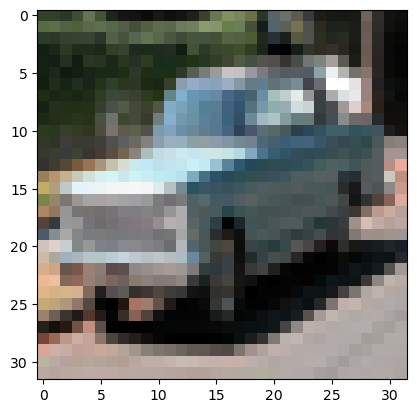

In [5]:
plt.imshow(x_train[32])

### Comenzaremos con una limpieza de datos

In [6]:
#aca llevamos los valores de 0 a 1 para evitar cualquier tipo de sesgo
x_train= x_train.astype("float32")
x_test= x_test.astype("float32")

In [7]:
#haremos una clasificación 
num_classes = len(np.unique(y_train))
y_train=to_categorical(y_train, num_classes) #usamos la función "to_categorical" que sabemos que nos crea un arreglo con 0 y 1 por cada dato
y_test= to_categorical(y_test, num_classes)


In [8]:
#Tenemos 10 diferentes posibles salidas
num_classes

10

### Normalización 

In [9]:
mean= np.mean(x_train)
std = np.std(x_train)

In [10]:
x_train= (x_train -mean)/(std+1e-7)
x_test= (x_test -mean)/(std+1e-7)

### Ahora que tenemos los datos mas organizados realizaremos una división de los datos entre validación , entrenamiento y test

In [11]:
(x_train ,x_valid)= x_train[5000:], x_train[:5000]
(y_train ,y_valid)= y_train[5000:], y_train[:5000]

print("x_train shape: " ,x_train.shape[0])

print("train ", x_train.shape[0])
print("val ", x_valid.shape[0])
print("test ", x_test.shape[0])


x_train shape:  45000
train  45000
val  5000
test  10000


### Crearemos el modelo de CNN

In [12]:
base_filtros=32
w_regularizer=1e-4

In [13]:
model=Sequential()
#primero tendremos una capa de convolución y luego una de activación
#conv1
model.add(Conv2D(base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer),input_shape=(32,32,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())

#conv2
model.add(Conv2D(base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#conv3
model.add(Conv2D(2*base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#conv4
model.add(Conv2D(2*base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#conv5
model.add(Conv2D(4*base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())

#conv6
model.add(Conv2D(4*base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#Clasificacion - flatten 
model.add(Flatten())
model.add(Dense(num_classes,activation="softmax"))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [14]:
datagen= ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

In [15]:
from tensorflow.keras import optimizers

## entrenaremos el modelo

In [16]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(),
             metrics=["accuracy"])

In [17]:
#hist= model.fit(x_train, y_train, 
 #               batch_size=32, 
 #               epochs=15,
  #              validation_data=(x_valid,y_valid),
  #              verbose=2, shuffle=True
  #             )

In [18]:
checkpoint=ModelCheckpoint("mi_mejor_modelo.hdf5",verbose=1,save_best_only=True,monitor="val_accuracy")

In [19]:
hist= model.fit(datagen.flow(x_train,y_train,
                      batch_size=128),
          callbacks=[checkpoint],
         steps_per_epoch=x_train.shape[0]//128 ,
         epochs=120,
         verbose=2,
         validation_data=(x_valid,y_valid))

Epoch 1/120


2023-03-29 19:08:22.677246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_accuracy improved from -inf to 0.29940, saving model to mi_mejor_modelo.hdf5
351/351 - 35s - loss: 2.2327 - accuracy: 0.3219 - val_loss: 2.1018 - val_accuracy: 0.2994 - 35s/epoch - 101ms/step
Epoch 2/120

Epoch 2: val_accuracy improved from 0.29940 to 0.47900, saving model to mi_mejor_modelo.hdf5
351/351 - 24s - loss: 1.7260 - accuracy: 0.4379 - val_loss: 1.5361 - val_accuracy: 0.4790 - 24s/epoch - 68ms/step
Epoch 3/120

Epoch 3: val_accuracy improved from 0.47900 to 0.52540, saving model to mi_mejor_modelo.hdf5
351/351 - 23s - loss: 1.5520 - accuracy: 0.5004 - val_loss: 1.4878 - val_accuracy: 0.5254 - 23s/epoch - 67ms/step
Epoch 4/120

Epoch 4: val_accuracy improved from 0.52540 to 0.57460, saving model to mi_mejor_modelo.hdf5
351/351 - 24s - loss: 1.4076 - accuracy: 0.5415 - val_loss: 1.3428 - val_accuracy: 0.5746 - 24s/epoch - 68ms/step
Epoch 5/120

Epoch 5: val_accuracy improved from 0.57460 to 0.63160, saving model to mi_mejor_modelo.hdf5
351/351 - 24s - loss: 1.3152

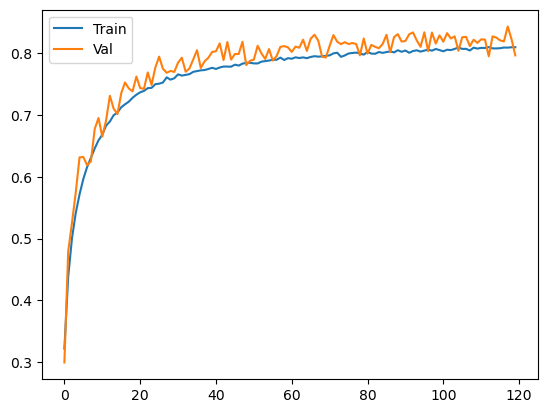

In [20]:
plt.plot(hist.history["accuracy"],label="Train")
plt.plot(hist.history["val_accuracy"],label="Val")
plt.legend()
plt.show()

**Vemos que el comportamiento es muy óptimo, sin overfitting, siempre aumentando su accuracy**

In [21]:
model2=model
model2.load_weights("./mi_mejor_modelo.hdf5")

In [22]:
model2.evaluate(x_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6530 - accuracy: 0.8307


[0.6529817581176758, 0.8306999802589417]

Entonces vemos que el accuracy aumenta bastante, al 82% 